Refers to [XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)

Based on https://www.kaggle.com/justdoit/rossmann-store-sales/xgboost-in-python-with-rmspe/code

Public Score :  0.11389

Private Validation Score :  0.096959


In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import matplotlib
from IPython.display import  display
matplotlib.use("Agg") #backends: each of the matplotlib output capabilities is called a backend; 
#http://matplotlib.org/faq/usage_faq.html
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# Start of main script
# Change the data type to reduce the storage size
start_time=time.time()
print("Load the training, test and store data using pandas")
types={
    'CompetitionOpenSinceMonth':np.dtype(int),
    'CompetitionOpenSinceYear':np.dtype(int),
    'StateHoliday':np.dtype(str),
    'Promo2SinceWeek':np.dtype(int),
    'Promo2SinceYear':np.dtype(int),
    'SchoolHoliday':np.dtype(float),
    'PromoInterval':np.dtype(str)
    
    
}

train=pd.read_csv("data/train.csv",parse_dates=[2],dtype=types)
test=pd.read_csv("data/test.csv",parse_dates=[3],dtype=types)
store=pd.read_csv('data/store.csv')
print("--- {:,.6f} seconds ---" .format (time.time() - start_time))

Load the training, test and store data using pandas
--- 1.424237 seconds ---


In [3]:
# Find Whether which store is open or not
print("---------Print Train NaN Row---------")
display(train[train.isnull().any(axis=1)])
print("---------Print Test NaN Row---------")
display(test[test.isnull().any(axis=1)])
test.fillna(1,inplace=True)
print("---------Print Test NaN Row after replacing---------")
display(test[test.isnull().any(axis=1)])

---------Print Train NaN Row---------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


---------Print Test NaN Row---------


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0.0
1335,1336,622,3,2015-09-16,NaN,1,0,0.0
2191,2192,622,2,2015-09-15,NaN,1,0,0.0
3047,3048,622,1,2015-09-14,NaN,1,0,0.0
4759,4760,622,6,2015-09-12,NaN,0,0,0.0
5615,5616,622,5,2015-09-11,NaN,0,0,0.0
6471,6472,622,4,2015-09-10,NaN,0,0,0.0
7327,7328,622,3,2015-09-09,NaN,0,0,0.0
8183,8184,622,2,2015-09-08,NaN,0,0,0.0
9039,9040,622,1,2015-09-07,NaN,0,0,0.0


---------Print Test NaN Row after replacing---------


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday


In [4]:
print("Consider only open stores for training. Closed stores won't count into score")
train=train[train['Open']!=0]
print("Use only Sales bigger than zero,")
train=train[train['Sales']>0]

Consider only open stores for training. Closed stores won't count into score
Use only Sales bigger than zero,


In [5]:
print("Merge with Store data")
train=pd.merge(train, store,on='Store')
test=pd.merge(test,store,on='Store')

Merge with Store data


In [6]:
# Learn this method to build features for both train and test

# Gather some features
def build_features(features,data):
    #remove NaNs
    data.fillna(0,inplace=True)
    data.loc[data['Open'].isnull(),'Open']=1
    
    # Use some properties directly
    features.extend(['Store','CompetitionDistance','Promo','Promo2','SchoolHoliday'])
    
    # Label encode some features
    features.extend(['StoreType','Assortment','StateHoliday'])
    mappings={'0':0,'a':1,'b':2,'c':3,'d':4}
    data.StoreType.replace(mappings,inplace=True)
    data.Assortment.replace(mappings,inplace=True)
    data.StateHoliday.replace(mappings,inplace=True)
    
    features.extend(['DayOfWeek','Month','Day','Year','WeekOfYear'])
    data['Year']=data.Date.dt.year
    data['Month']=data.Date.dt.month
    data['Day']=data.Date.dt.day
    data['DayOfWeek']=data.Date.dt.dayofweek
    data['WeekOfYear']=data.Date.dt.weekofyear
    
    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen']=12*(data.Year-data.CompetitionOpenSinceYear)+(data.Month-data.CompetitionOpenSinceMonth)
    
    #Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen']=12*(data.Year-data.Promo2SinceYear)+(data.WeekOfYear-data.Promo2SinceWeek)/4.0
    data['PromoOpen']=data.PromoOpen.apply(lambda x:x if x>0 else 0)
    data.loc[data.Promo2SinceYear==0,'PromoOpen']=0
    
    #Indicate that sales on that day in promo interval
    features.append('IsPromoMonth')
    month2str={
        1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
        7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'    
    }
    data['monthStr']=data.Month.map(month2str)
    data.loc[data.PromoInterval==0,'PromoInterval']=''
    data['IsPromoMonth']=0
    for interval in data.PromoInterval.unique():
        if interval!='':
            for month in interval.split(','):
                data.loc[(data.monthStr==month)&(data.PromoInterval==interval),'IsPromoMonth']=1
    
    
    
    
    
    
    
    


features=[]
print('Augment features')
build_features(features, train)
build_features([], test)
print(features)





Augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


In [7]:
print('training data processed')
params={
    'objective':'reg:linear',
    'booster':'gbtree',
    'eta':0.3,
    'max_depth':10,
    'subsample':0.9,
    'colsample_bytree':0.7,
    'silent':1,
    'seed':1301
}
num_boost_round=300

print('Train a XGBoost model')
X_train,X_valid=train_test_split(train,test_size=0.012,random_state=10)
y_train=np.log1p(X_train.Sales)
y_valid=np.log1p(X_valid.Sales)

training data processed
Train a XGBoost model


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 26 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int64
SchoolHoliday                844338 non-null float64
StoreType                    844338 non-null int64
Assortment                   844338 non-null int64
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
P

In [11]:

dtrain=xgb.DMatrix(X_train[features],y_train)
dvalid=xgb.DMatrix(X_valid[features],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=100,feval=rmspe_xg,verbose_eval=True)

training data processed
Train a XGBoost model


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996830	eval-rmspe:0.996828
[1]	train-rmspe:0.981414	eval-rmspe:0.981413
[2]	train-rmspe:0.937928	eval-rmspe:0.937948
[3]	train-rmspe:0.856420	eval-rmspe:0.856414
[4]	train-rmspe:0.743915	eval-rmspe:0.743456
[5]	train-rmspe:0.619839	eval-rmspe:0.618119
[6]	train-rmspe:0.505827	eval-rmspe:0.501297
[7]	train-rmspe:0.416382	eval-rmspe:0.407330
[8]	train-rmspe:0.352812	eval-rmspe:0.339692
[9]	train-rmspe:0.319409	eval-rmspe:0.302301
[10]	train-rmspe:0.298488	eval-rmspe:0.276217
[11]	train-rmspe:0.288719	eval-rmspe:0.263493
[12]	train-rmspe:0.280855	eval-rmspe:0.252323
[13]	train-rmspe:0.270708	eval-rmspe:0.241224
[14]	train-rmspe:0.260610	eval-rmspe:0.226547
[15]	train-rmspe:0.260467	eval-rmspe:0.226868
[16]	train-rmspe:0.249363	eval-rmspe:0.223905
[17]	train-rmspe:0.248612	eval-rmspe:0.223629
[18]	train-rmspe:0.236344	eval-rmspe:0.210989
[19]	train-rmspe:0.235437	eval-rmspe:0.209829
[20]	train-rmspe:0.234261	eval

In [16]:
print('Validating')
yhat=gbm.predict(xgb.DMatrix(X_valid[features]))
error=rmspe(X_valid.Sales.values,np.expm1(yhat))
print('RMSPE:{:.6f}'.format(error))



print('Make predictions on the test set')
dtest=xgb.DMatrix(test[features])
test_probs=gbm.predict(dtest)

#make submission
result=pd.DataFrame({"Id":test['Id'],'Sales':np.expm1(test_probs)})

result.to_csv("Kaggle_Kernel_3_XGBoost_Feature_Importance/xgboost_10_submission.csv",index=False)

Validating
RMSPE:0.095589
Make predictions on the test set


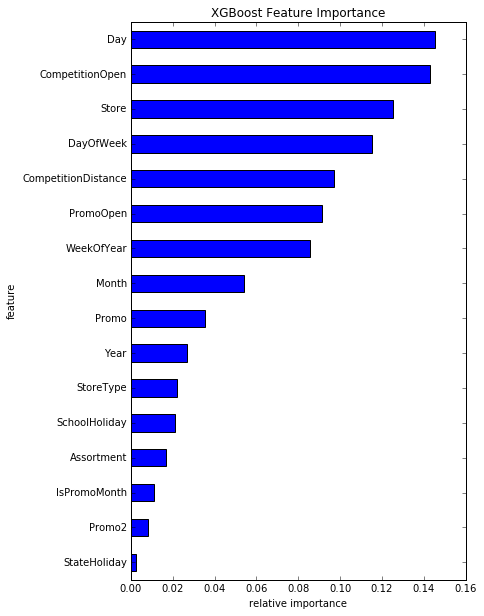

In [24]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
def create_feature_map(features):
    outfile=open('xgb.fmap','w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()
create_feature_map(features)
importance=gbm.get_fscore(fmap='xgb.fmap')
importance=sorted(importance.items(),key=operator.itemgetter(1))

df=pd.DataFrame(importance,columns=['feature','fscore'])
df['fscore']=df['fscore']/df['fscore'].sum()

featp=df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp=featp.get_figure()
fig_featp.savefig('Kaggle_Kernel_3_XGBoost_Feature_Importance/feature_importance_xgb.png',bbox_inches='tight',pad_inches=1)


